<a href="https://colab.research.google.com/github/zhuodannychen/ai-search-engine/blob/main/AISearch_DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade google-cloud-bigquery

In [ ]:
!pip install nltk beautifulsoup4

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [21]:
import pandas as pd


project_id = 'ai-semantic-search'

query = """
WITH RankedAnswers AS (
  SELECT
    q.id AS question_id,
    q.title AS question_title,
    q.body AS question_body,
    q.score AS question_score,
    q.tags AS question_tags,
    a.id AS answer_id,
    a.body AS answer_body,
    a.score AS answer_score,
    ROW_NUMBER() OVER (PARTITION BY q.id ORDER BY a.score DESC) as answer_rank
  FROM
    `bigquery-public-data.stackoverflow.posts_questions` AS q
  LEFT JOIN
    `bigquery-public-data.stackoverflow.posts_answers` AS a
  ON
    q.id = a.parent_id
  WHERE
    EXTRACT(YEAR FROM q.creation_date) = 2019
    AND a.score > 1
)

SELECT
  question_id,
  question_title,
  question_body,
  question_score,
  question_tags,
  answer_id,
  answer_body,
  answer_score
FROM
  RankedAnswers
WHERE
  answer_rank <= 3
ORDER BY
  question_score DESC, answer_score DESC
LIMIT 100
"""

df = pd.read_gbq(query, project_id=project_id, dialect='standard')


In [22]:
df.head()

,question_id,question_title,question_body,question_score,question_tags,answer_id,answer_body,answer_score
0,55921442,"How to fix ""ReferenceError: primordials is not...",<p>I have installed Node.js modules by 'npm in...,804,node.js|sass|gulp|gulp-sass,55926692,<p>I hit the same error. I suspect you're usin...,868
1,55921442,"How to fix ""ReferenceError: primordials is not...",<p>I have installed Node.js modules by 'npm in...,804,node.js|sass|gulp|gulp-sass,58394828,<p>We encountered the same issue when updating...,820
2,55921442,"How to fix ""ReferenceError: primordials is not...",<p>I have installed Node.js modules by 'npm in...,804,node.js|sass|gulp|gulp-sass,60921145,<h1>Fix it in one minute:</h1>\n<p>Just follow...,473
3,58211880,"""Uncaught SyntaxError: Cannot use import state...",<p>I'm using ArcGIS JSAPI 4.12 and wish to use...,796,javascript|ecmascript-6|arcgis|arcgis-js-api,58679392,<p>I got this error because I forgot the <code...,425
4,58211880,"""Uncaught SyntaxError: Cannot use import state...",<p>I'm using ArcGIS JSAPI 4.12 and wish to use...,796,javascript|ecmascript-6|arcgis|arcgis-js-api,64655153,<h2>Update For Node.js / NPM</h2>\n<p>Add <a h...,375


In [23]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def clean_html(raw_html):
    """Remove HTML tags from a string."""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text()

def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    """Tokenize and lemmatize a given text."""
    lemmatizer = WordNetLemmatizer()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    # Lemmatize each token based on its part of speech
    lemmas = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos)) for token, pos in pos_tags]
    return ' '.join(lemmas)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
def preprocess_text(raw_html):
    text = clean_html(raw_html)
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text

def decontract(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['question_title'] = df['question_title'].apply(preprocess_text)
df['question_body'] = df['question_body'].apply(preprocess_text)
df['answer_body'] = df['answer_body'].apply(preprocess_text)
df['question_title'] = df['question_title'].apply(decontract)
df['question_body'] = df['question_body'].apply(decontract)
df['answer_body'] = df['answer_body'].apply(decontract)

df['lemmatized_question_title'] = df['question_title'].apply(lemmatize_text)
df['lemmatized_question_body'] = df['question_body'].apply(lemmatize_text)
df['lemmatized_answer_body'] = df['answer_body'].apply(lemmatize_text)


<ipython-input-23-632e339656fb>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_html, "html.parser")


In [26]:
df['lemmatized_question_body'].head()

0    I have instal Node.js module by 'npm install '...
1    I have instal Node.js module by 'npm install '...
2    I have instal Node.js module by 'npm install '...
3    I be use ArcGIS JSAPI 4.12 and wish to use Spa...
4    I be use ArcGIS JSAPI 4.12 and wish to use Spa...
Name: lemmatized_question_body, dtype: object

In [27]:
print(df.info())
print(df[df.duplicated()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   question_id                100 non-null    Int64 
 1   question_title             100 non-null    object
 2   question_body              100 non-null    object
 3   question_score             100 non-null    Int64 
 4   question_tags              100 non-null    object
 5   answer_id                  100 non-null    Int64 
 6   answer_body                100 non-null    object
 7   answer_score               100 non-null    Int64 
 8   lemmatized_question_title  100 non-null    object
 9   lemmatized_question_body   100 non-null    object
 10  lemmatized_answer_body     100 non-null    object
dtypes: Int64(4), object(7)
memory usage: 9.1+ KB
None
Empty DataFrame
Columns: [question_id, question_title, question_body, question_score, question_tags, answer_id, answer_body, a

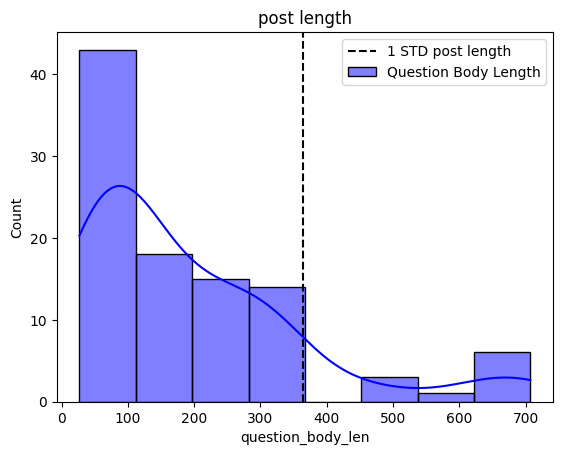

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df['question_body_len'] = df['lemmatized_question_body'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['question_body_len'].mean() + df['question_body_len'].std()).astype(int)
sns.histplot(df['question_body_len'], kde=True, color='b', label='Question Body Length')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='1 STD post length')
plt.title('post length'); plt.legend()
plt.show()

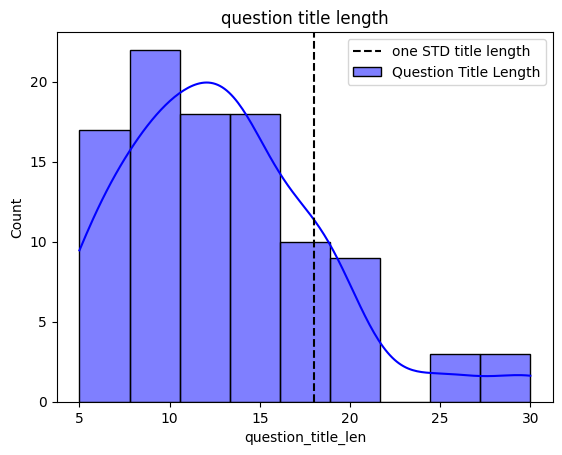

In [35]:
df['question_title_len'] = df['lemmatized_question_title'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['question_title_len'].mean() + df['question_title_len'].std()).astype(int)
sns.histplot(df['question_title_len'], kde=True, color='b', label='Question Title Length')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='one STD title length')
plt.title('question title length'); plt.legend()
plt.show()

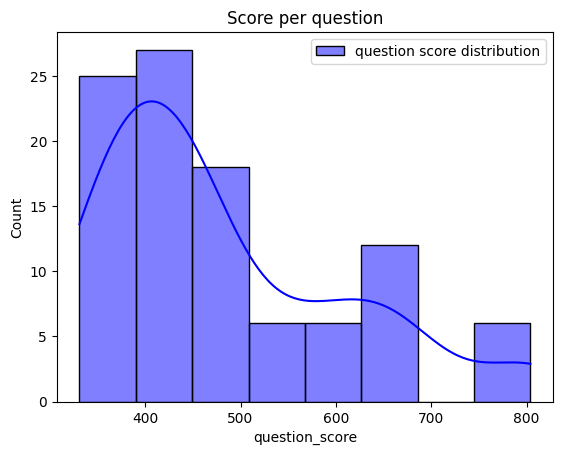

In [36]:
sns.histplot(df['question_score'], kde=True, color='b', label='question score distribution')
plt.title('Score per question'); plt.legend()
plt.show()

In [37]:
df.to_csv('stackoverflow-100', index=False)